<a href="https://colab.research.google.com/github/NanakiOhashi-JP/AI-Soft-Prac/blob/main/12_GitHub_RNN/12_GitHub_RNN/GitHub-RNN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 人工知能とソフトコンピューティング 第12回 RNN 演習(GitHubデータを使った予測・後半）

In [10]:
!pip install pytorch_lightning torchmetrics

## 分析対象となるデータの準備

ここでは Apache HTTPD の開発履歴（1996/7/3～2023/12/23：27年間 33763 コミット）のデータから，あるコミットでのコード変更行数を予測するタスクを想定

In [11]:
from pathlib import Path # ファイルパスの取り扱い

# ベースパスの設定
base_path = '.'
# csvファイル名の設定
csv_file_name = Path('apache_httpd.csv')
# csv_file_name = Path('owncloud_android.csv') # 別のcsvファイルを使用する場合はこちらを有効化

### ステップ1
必要となるライブラリをインポート（tensorflowの使える環境を選択する必要あり）

In [12]:
import matplotlib.pyplot as plt # グラフ描画
import pandas as pd # データの取り扱い
from pandas import Series, DataFrame
from sklearn.preprocessing import StandardScaler # データの正規化（平均・標準偏差）
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error #

from datetime import datetime, timezone, date, timedelta # 時間関係（日付）の計算
import numpy as np # 数値取扱い
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as L
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchmetrics import Accuracy

### ステップ2
CSVファイルからデータを読み込み，その内容を確認する

,Unnamed: 0,commit_hash,add,delete,changed,timestamp,message
0,0,db68a0c656fd42876e5fa5979b0637904785485d,0,0,0,1996-07-03 06:18:15+00:00,New repository initialized by cvs2svn.
1,1,71aa1343b0e4001170dbaf0a3b144d7c4028ef7b,0,0,0,1996-07-03 06:18:15+00:00,Added a test index.html file and an image to ...
2,2,2ada5933c85b2ca45770c2df27e2d292667f36c4,1725,0,1725,1996-11-18 19:51:08+00:00,New manual setup. This is the current docs fo...
3,3,b2ab672f99920e5019879b8a0e5e0e2808f2f774,3183,0,3183,1996-11-21 08:12:53+00:00,Moving files to mod/
4,4,359ae809b83a85f843bc3a7149af4ee0fd1e61c2,1024,0,1024,1996-11-21 08:16:33+00:00,Moved core.html and modules.html to appropria...


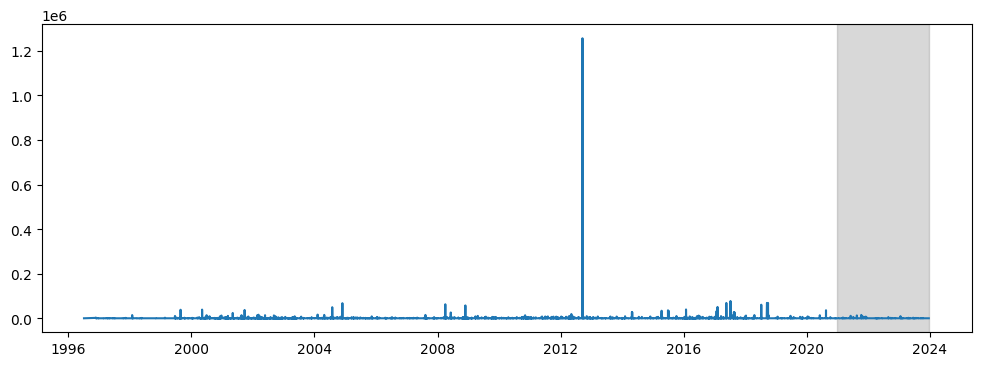

In [13]:
def plot_df(df):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(df['timestamp'], df['changed'])
    start_datetime = datetime(2021, 1, 1)
    end_datetime = datetime(2023, 12, 31)
    ax.axvspan(start_datetime, end_datetime, color="gray", alpha=0.3) # 予測する部分を色付けして表示

df = pd.read_csv(Path(base_path, "12_data", csv_file_name)) # csv ファイルからの読み込み
df.loc[:, 'timestamp'] = [datetime.strptime(x, ' %a %b %d %H:%M:%S %Y %z') for x in df['timestamp']] # timestamp のフォーマットを変換（文字列からdatetimeへ）

plot_df(df)
df.head() # 先頭部分のデータを表示

### ステップ3
* 読み込んだコミットデータの個数，変更行の最小値，変更行の最大値を確認
* 読み込んだデータを正規化するための層を設定（平均値を0，標準偏差を1に正規化）

In [14]:
def make_base_data(df):
    # 読み込んだ変更行数の値（データフレーム形式）を numpy形式の 2次元配列に変換
    base_data = df.changed.values.reshape(-1, 1)
    # データ個数，最小変更行数，最大変更行数の表示
    print("コミット数 = {}".format(len(base_data)))
    print("コミット当たり最小の変更行数 = {} 行".format(np.min(base_data)))
    print("コミット当たり最大の変更行数 = {} 行".format(np.max(base_data)))
    return base_data

def cleansing_by_changed(df, base_data):
    # 突発的に多く変更される場合があるので，クレンジングを実施．
    # 平均値＋3σ（正規分布であれば，99.7%から外れる）のデータを除外．
    df_local = df.copy()
    avg = np.average(base_data)
    std = np.std(base_data)
    df_local.drop(df_local[df_local["changed"] > avg + 3 * std].index, inplace = True)
    plot_df(df_local)
    return df_local.reset_index()

base_data = make_base_data(df)

#print("クレンジング実施：")
#df = cleansing_by_changed(df, base_data)
#base_data = make_base_data(df)

scaler = StandardScaler() # scikit-learn のスケーラ
scaler.fit(base_data) # 平均・標準偏差の計算
base_data = scaler.transform(base_data) # 標準化変換

コミット数 = 33763
コミット当たり最小の変更行数 = 0 行
コミット当たり最大の変更行数 = 1256714 行


## 訓練用データとテスト用データの作成
一定の長さのコミットあたり変更行数の系列を作成
* 直近 sequence_length 回をタイムステップとし，その回数のコミット当たり変更行数から次コミットの変更行数を推定する
* sequence_length 回の変更行数の系列（入力データ）と sequence_length + 1 回目の変更行数（正解データ）を作成
* 訓練用データはプロジェクト開始～2020年，テスト用データは 2021年以降とする
    * ただし，訓練用データの開始年は，変更できるようにする．

### ステップ4
系列長（sequence_length）とバッチサイズ（batch_size）を設定

* 系列長は RNN に入力する温度系列の長さ（タイムステップ）
* バッチサイズは RNN が重みを計算する際（最適化アルゴリズム）に与えるミニバッチサイズ

In [15]:
sequence_length = 100 # 遡って何コミット分の変更行数データから次のコミットの変更行数を予測するか

### ステップ5
訓練用データとテスト用データを分割
* 訓練用データは 開始年（1996が最初）/1/1 ～ 2020/12/31 の最大25年間 (クレンジングしていない場合は 32406件)
* テスト用データは 2021/1/1 以降の(クレンジングしていない場合は) 1357件
* 過去25年分のコミットデータを用いて RNNを訓練して，2021 以降約3年間のコミット当たり変更行数を予測
* 実際の予測では，sequence_length 回分のデータを入力して次のコミットの変更行数を予測

In [16]:
# 訓練用データ start_year/1/1 ～ 2020/12/31
start_year = 1996
#start_year = 2016
training_data = base_data[ df.index[df["timestamp"] >= datetime(start_year, 1, 1, 0, 0, 0, 0, timezone.utc)].tolist()[0]:df.index[df["timestamp"] >= datetime(2021, 1, 1, 0, 0, 0, 0, timezone.utc)].tolist()[0]]
# テスト用データ 2021/1/1 以降
test_data = base_data[df.index[df["timestamp"] >= datetime(2021, 1, 1, 0, 0, 0, 0, timezone.utc)].tolist()[0] :]

# 分割したデータの形式を確認
print(training_data.shape)
print(test_data.shape)

(32406, 1)
(1357, 1)


### ステップ6
* 直近 sequence_length 回分の連続系列を作り出す関数（generate_dataset）を定義
* 定義した関数を訓練用データ，テスト用データに適用

In [17]:
def generate_dataset(data, length): # length日分の連続系列を作り出す
    X = []
    y = []
    for i in range(len(data) - length):
        p = i + length
        X.append(data[i : p])
        y.append(data[p])
    return np.array(X), np.array(y)

# *_seqs は2次元配列：長さ sequence_length の温度値からなる系列が並んだもの
# *_targets は1次元配列：予測目標である温度値が並んだもの
training_seqs, training_targets = generate_dataset(training_data, sequence_length) # 訓練用の系列と正解値
test_seqs, test_targets = generate_dataset(test_data, sequence_length) # テスト用の系列と正解値
# RNNへの入力用に3階のテンソルの変換（データ個数，シーケンス長，データ次元数）
training_seqs = np.reshape(training_seqs, (-1, sequence_length, 1))
test_seqs = np.reshape(test_seqs, (-1, sequence_length, 1))
# 具体的なデータやその形式を確認したい場合は次の4行のコメントを外す
# print(training_seqs)
# print(training_seqs.shape)
# print(training_targets)
# print(training_targets.shape)

# NumPy配列をPyTorchのテンソルに変換
training_seqs = torch.Tensor(training_seqs)
training_targets = torch.Tensor(training_targets)
test_seqs = torch.Tensor(test_seqs)
test_targets = torch.Tensor(test_targets)

# TensorDataset に変換
# 検証用データを訓練用データの末尾から20%分抽出
val_size = int(len(training_seqs) * 0.2)
train_size = len(training_seqs) - val_size
train_dataset = TensorDataset(training_seqs[:train_size], training_targets[:train_size])
val_dataset = TensorDataset(training_seqs[train_size:], training_targets[train_size:])

## RNNの構造定義と訓練

### ステップ7
RNNの構造定義
* 基本的なRNNを適用
* RNN を LSTM や GRU に変更可能
* num_lahyers オプションで RNNを複数層重ねることもできる
* bidirectional オプションを用いることで双方向へのデータの伝播も可能（隠れ層のサイズの調整は必要）

RNNの訓練方法
* 最適化アルゴリズムは Adam を使用
* 損失関数は平均二乗誤差（Mean Squared Error：MSE）を使用

In [18]:
class RNN(L.LightningModule):
    def __init__(self, input_size, rnn_hidden_size, lr):
        super().__init__()
        self.save_hyperparameters() # ハイパーパラメータを保存
        self.example_input_array = torch.zeros((1, sequence_length, 1)) # データ数1，シーケンス長 sequence_length，データ次元数 1

        # RNN: 最も単純なRNN層を定義．系列データをずらしながら入力
        #            ユニット数（層の出力の次元数）64 (変更可）のデータを次の層へ出力
        #            活性化関数は tanh（ハイパボリックタンジェント：変更可）
        self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size, nonlinearity='tanh',
                          num_layers=1, bidirectional=False,
                          batch_first=True)

        # RNN層をLSTMにする場合
        #self.rnn = nn.LSTM(input_size=input_size, hidden_size=rnn_hidden_size,
        #                     batch_first=True)
        # RNN層をGRUにする場合
        #self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size,
        #                    batch_first=True)
        #
        # RNN層を複数にする場合は num_layers を増やす
        #self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size, nonlinearity='tanh',
        #                    num_layers=2,
        #                    batch_first=True)
        # RNN層を双方向（前の時刻，後の時刻への伝播を両方含む）ものにする場合，bidirectional=Trueにする
        # 両方向の hidden_size を足し合わせたものが 次のLayerに入力されるので、rnn_hidden_sizeを2で割っている
        #self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size // 2, nonlinearity='tanh',
        #                    bidirectional=True,
        #                    batch_first=True)
        #
        # Layer: 全結合のニューロン層 ユニット数 1，活性化関数（出力関数） linear（変換なしでそのまま出力）
        self.dense = nn.Linear(in_features=rnn_hidden_size, out_features=1)
        # 双方向RNNの場合は in_features=rnn_hidden_size * 2 にする
        #self.dense = nn.Linear(in_features=rnn_hidden_size * 2, out_features=1)

        # 損失関数: 回帰問題なので平均二乗誤差（MSE）
        self.criterion = nn.MSELoss()
        # 学習率
        self.lr = lr

    def forward(self, x):
        # RNN層への入力と実行
        # rnn_out: 全タイムステップの出力 (batch_size, sequence_length, rnn_units)
        # h_n: 最終層の最後の隠れ状態 (num_layers * num_directions, batch_size, rnn_units)
        rnn_out, h_n = self.rnn(x)
        # 最終時刻の出力を取り出す
        out = rnn_out[:, -1, :]
        # 最終時刻の出力を全結合層へ入力
        out = self.dense(out) # 全結合層への入力
        return out

    def configure_optimizers(self):
        # オプティマイザ:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # on_epoch=True でエポック終了時に平均値を記録
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 訓練データのバッチを使って損失を計算
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # on_epoch=True でエポック終了時に平均値を記録
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # 訓練データのバッチを使って損失を計算
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # on_epoch=True でエポック終了時に平均値を記録
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

ModelSummary(RNN(input_size=1, rnn_hidden_size=64, lr=0.001))

  | Name      | Type    | Params | Mode  | FLOPs | In sizes    | Out sizes                 
-------------------------------------------------------------------------------------------------
0 | rnn       | RNN     | 4.3 K  | train | 832 K | [1, 100, 1] | [[1, 100, 64], [1, 1, 64]]
1 | dense     | Linear  | 65     | train | 128   | [1, 64]     | [1, 1]                    
2 | criterion | MSELoss | 0      | train | 0     | ?           | ?                         
-------------------------------------------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
832 K     Total Flops

### ステップ8
作成したモデルの訓練
* エポック数 100（ただし損失の値に変化がなくなったら訓練を打ち切る EarlyStopping コールバックを利用）
* バッチサイズ 100 （100コミットを使って予測するので，それに合わせている）

In [19]:
epochs = 100 # 最大エポック数
batch_size = 100 # バッチサイズ
patience = 20 # 訓練を打ち切る場合でも最低20エポックまでは訓練する
learning_rate = 0.001 # 学習率

# 1. データローダーとモデルのインスタンス化

# 入力データ：training_seqs 気温の系列データ
# 正解データ：training_targets 各系列に対する翌日の気温
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# バッチサイズ：32（このセルの先頭部分の batch_size）
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

model_rnn = RNN(input_size=1, rnn_hidden_size=64, lr=learning_rate)

checkpoint_callback = L.callbacks.ModelCheckpoint(
    save_last=True,
)
# erly stopping コールバックの設定（検証データの損失が改善しなくなったら学習を終了する）
early_stopping_callback = L.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    mode='min'
)

log_folder = Path(base_path, "logs")
rnn_logger = L.loggers.CSVLogger(log_folder, name="rnn_" + csv_file_name.stem)
rnn_trainer = L.Trainer(
    max_epochs=epochs, # エポック数：100（このセルの先頭部分の epochs）
    logger=rnn_logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    deterministic=True,
    enable_progress_bar=True
)

# モデルの訓練
rnn_trainer.fit(model_rnn, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
checkpoint_path = checkpoint_callback.last_model_path
stopped_epoch = rnn_trainer.early_stopping_callback.stopped_epoch

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name      ┃ Type    ┃ Params ┃ Mode  ┃ FLOPs ┃    In sizes ┃                  Out sizes ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ rnn       │ RNN     │  4.3 K │ train │     0 │ [1, 100, 1] │ [[1, 100, 64], [1, 1, 64]] │
│ 1 │ dense     │ Linear  │     65 │ train │   128 │     [1, 64] │                     [1, 1] │
│ 2 │ criterion │ MSELoss │      0 │ train │     0 │           ? │                          ? │
└───┴───────────┴─────────┴────────┴───────┴───────┴─────────────┴────────────────────────────┘

Trainable params: 4.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.4 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 128

Output()

### ステップ9
訓練履歴の確認
* 訓練中のエポック毎の損失値（平均二乗誤差）の推移を描画
* ここでの損失は平均と標準偏差によってデータを標準化したものに対する値であることに注意
* グラフ描画の関数を定義して適用

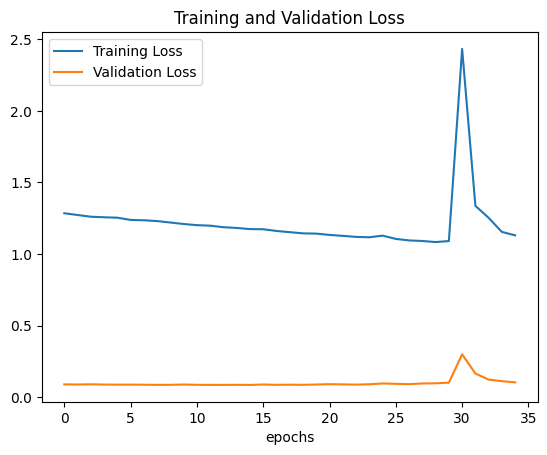

In [20]:
def load_history(log_path):
    log_file = Path(log_path, "metrics.csv")
    history = pd.read_csv(log_file)
    # 記録のタイミングにより欠損値があるため，欠損値のある行を削除
    train_history = history.dropna(subset=['train_loss']).reset_index(drop=True)
    val_history = history.dropna(subset=['val_loss']).reset_index(drop=True)
    return train_history, val_history

def show_loss_graphs(train_history, val_history, epochs, epoch_from = 0): # 訓練履歴（精度・損失）を描画する関数
    training_losses = train_history["train_loss"] # 訓練用データに対する損失
    validation_losses = val_history["val_loss"] # 評価用データに対する損失

    epochs_range = range(epoch_from, epochs + 1) # 1 から epochs までの描画範囲を指定
    figure = plt.figure()
    subplot = plt.subplot()
    subplot.plot(epochs_range, training_losses, label = "Training Loss") # 訓練用データに対する損失のグラフ描画
    subplot.plot(epochs_range, validation_losses, label = "Validation Loss") # 評価用データに対する損失のグラフ描画
    subplot.set_xlabel("epochs")
    subplot.legend()
    # plt.ylim(0, 0.2) # 複数のモデルに対して損失値のグラフを比べたい場合，この行のコメントを外し，固定の上限値，下限値を指定する
    plt.title("Training and Validation Loss")
    plt.show()

log_path = Path(log_folder, "rnn_" + csv_file_name.stem, f"version_{rnn_trainer.logger.version}")
rnn_train_history, rnn_val_history = load_history(log_path)
show_loss_graphs(rnn_train_history, rnn_val_history, stopped_epoch) # 損失値のグラフを描画

## 予測タスクの実行
テスト用データを与えてコミット当たり変更行数を予測する

## ステップ10
* 訓練したモデルに2021/1/1から2022/12/31までのデータを与えて予測
* 出力されるのは平均と標準偏差を用いて変換したものなので，逆変換

In [21]:
# 系列データを与えて予測
test_dataloader = DataLoader(
    test_seqs,
    batch_size=len(test_seqs),
    shuffle=False
)

predictions = rnn_trainer.predict(model_rnn, dataloaders=test_dataloader)
predictions = torch.cat(predictions, dim=0).numpy() # バッチごとの要素のリストを結合して1つのTensorにする

# 予測結果とテスト用の正解データを標準化逆変換
predictions_real = scaler.inverse_transform(predictions)
targets_real = scaler.inverse_transform(test_targets)

# 誤差に関する値を表示（平方根平均二乗誤差，平均絶対誤差，平均絶対パーセント誤差）
print("平方根平均二乗誤差（RMSE）= {}".format(np.sqrt(mean_squared_error(targets_real, predictions_real))))
print("平均絶対誤差（MAE）= {}".format(mean_absolute_error(targets_real, predictions_real)))

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

平方根平均二乗誤差（RMSE）= 868.6541928895322
平均絶対誤差（MAE）= 258.7340500579749


### ステップ11
予測結果のグラフ描画
* 2022/1/1から2022/12/31までの結果
* 2022/1から2022/12までの1ヶ月ずつの予測結果

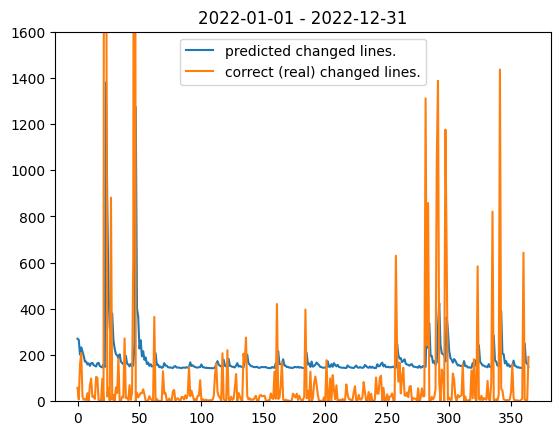

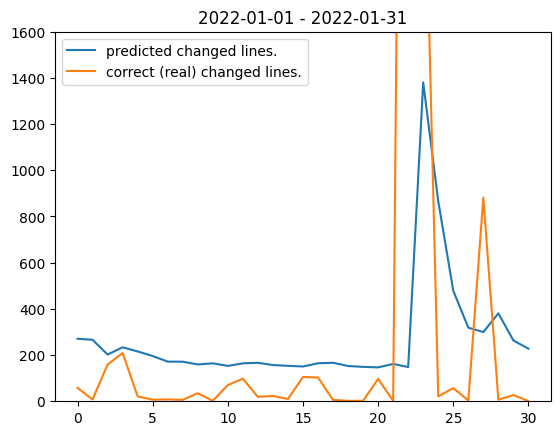

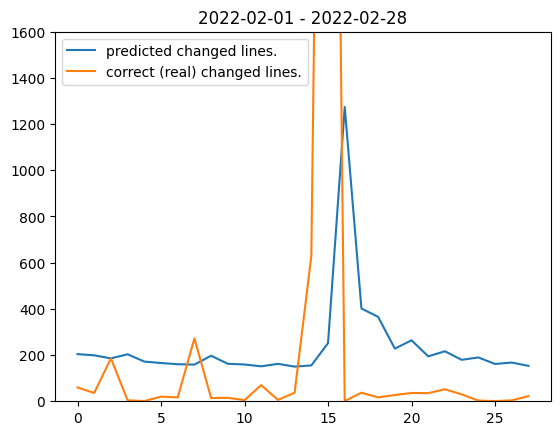

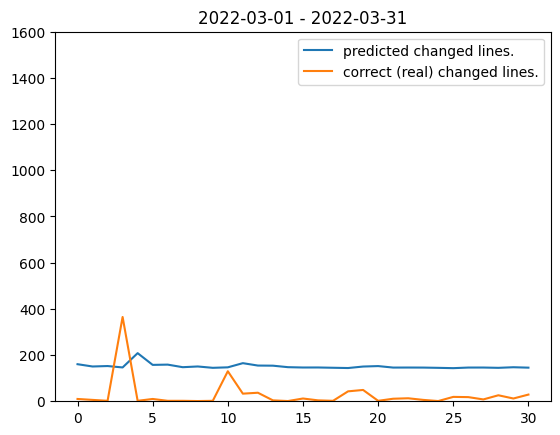

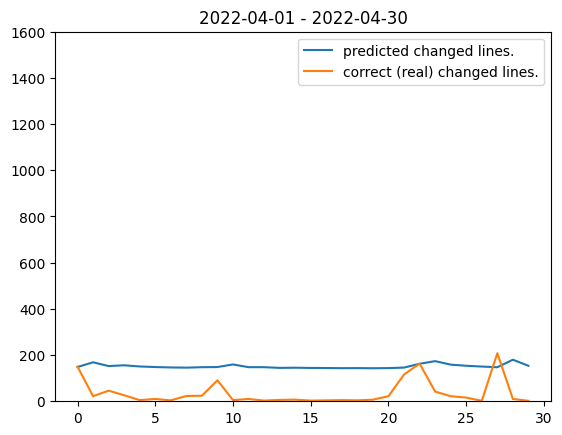

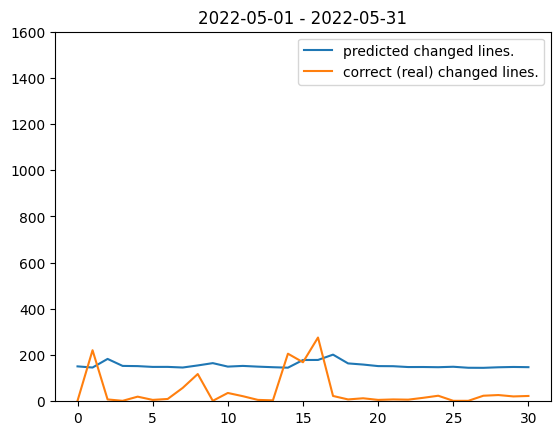

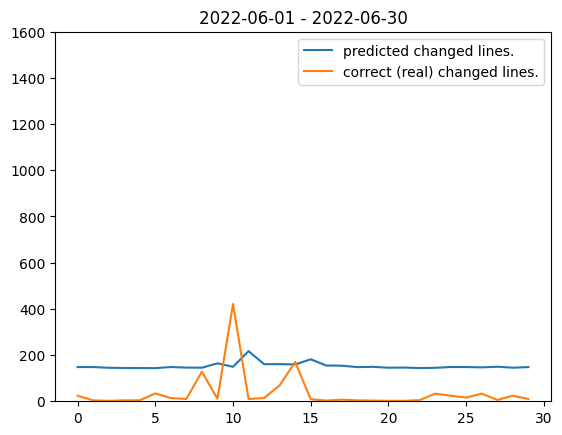

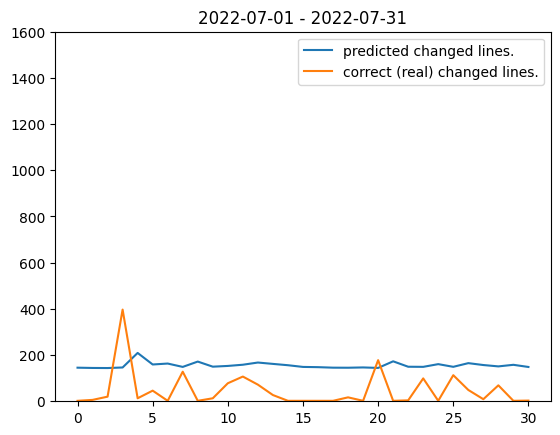

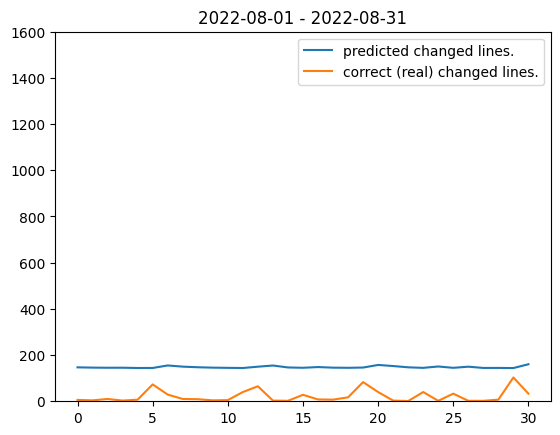

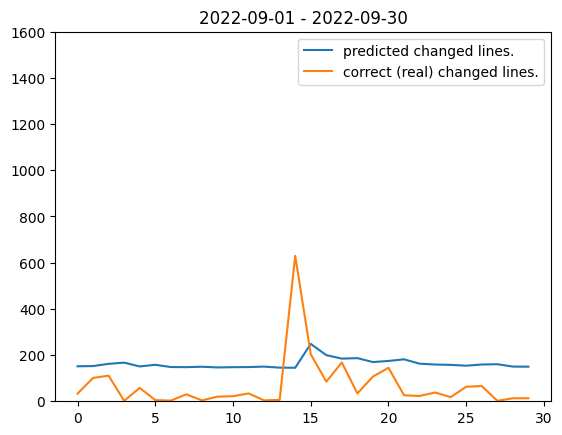

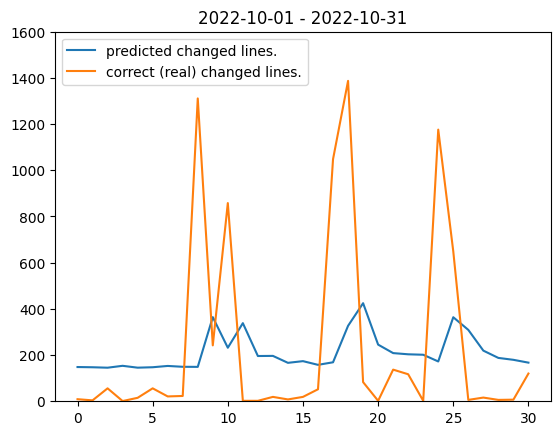

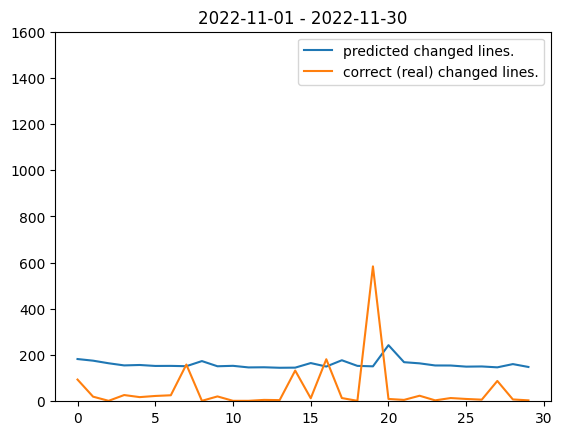

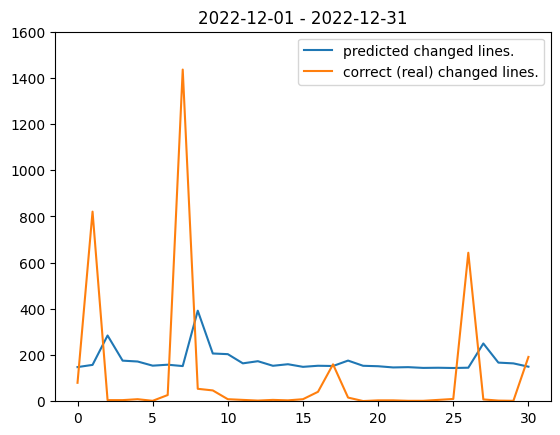

In [22]:
def show_result(predictions, targets, title = ""): # 予測結果と正解のグラフを表示する関数
    plt.plot(predictions, label = "predicted changed lines.")
    plt.plot(targets, label = "correct (real) changed lines.")
    plt.ylim(0, 1600.0) # グラフの比較ができるように行数の範囲を固定（0行～1600行）
    plt.title(title)
    plt.legend()
    plt.show()

# グラフ描画の開始日から終了日を指定して描画する関数を定義
# 開始日と終了日は 2022/1/1から2022/12/31までの間で指定（日付の間のエラーチェックなどはしていないので注意）
def show_result_with_start_and_end(start_date, end_date, offset, predictions, targets):
    # 予測結果・正解データの最初の日
    offset_date = date(year = 2021, month = 1, day = 1) + timedelta(days = offset)
    # 描画開始位置の計算
    diff_start = (start_date - offset_date).days
    # 描画終了位置の計算
    diff_end = (end_date - offset_date).days + 1
    # 予測値と実際の値（正解）のグラフ描画
    show_result(predictions[diff_start : diff_end],
                targets[diff_start : diff_end],
                title = "{}".format(start_date) + " - {}".format(end_date))

# 2022/1/1 から 2022/12/31 までの予測結果と実際の値（正解）を描画
# 以下，テストデータは 2021/1/1から2022/12/31 までの範囲でしか与えられておらず，
# 予測結果や正解（実際の値）はその範囲に対するもののみであることに注意，
# 範囲外の日付（年・月・日）を指定するとうまく動かない
show_result_with_start_and_end(date(year = 2022, month = 1, day = 1),
                               date(year = 2022, month = 12, day = 31),
                               offset = sequence_length, predictions = predictions_real, targets = targets_real)

# 2022/1 から一か月ごとに予測結果と実際の値（正解）を描画
for i in range(1, 13):
    if i == 12: # 12月だけ特別扱い
        ey = 2023
        em = 1
    else:
        ey = 2022
        em = i + 1
    # 各月の1日から最終日までのグラフを描画
    show_result_with_start_and_end(date(year = 2022, month = i, day = 1),
                                   date(year = ey, month = em, day = 1) - timedelta(days = 1),
                                   offset = sequence_length, predictions = predictions_real, targets = targets_real)